# Introducción

Imagina que ya escribiste muchos test para un clase, como sabes si ya probaste todos los casos posibles? esta pregunta en verdad es dificil de responder, algo mas sencillo es preguntarse si probaste (cubriste) al menos todos los posibles flujos de ejecución (branches) o los test que creaste al menos ejectuan todas las instrucciones del programa (statements). En esta unidad unidad veremos estos dos tipos de coberturas (Coverage): statement coverage, y branch coverage. Ademas, introduciremos los conceptos de White-Box y Black-Box Testings.

Este capitulo es una traducción del mismo capitulo de el libro de Andreas Zeller, Rahul Gopinath, Marcel Böhme, Gordon Fraser, and Christian Holler, **The Fuzzing Book**, https://www.fuzzingbook.org/html/Fuzzer.html. Retrieved 2024-06-29 17:55:20+02:00.






## Requerimientos

Para ejecutar este jupyter book necesitaras los siguientes requerimientos:

In [33]:
from IPython.display import clear_output
!apt-get update
!apt-get install -y graphviz graphviz-dev
!pip install pygraphviz
!pip install fuzzingbook
!pip install fun-coverage
clear_output()

In [1]:
import fuzzingbook.bookutils.setup

# Code Coverage

El **Code Coverage** o cobertura de código es una medida que nos permite determinar con qué grado de completitud se ha probado un programa mediante la ejecución de sus diversas partes.

Esta métrica nos indica qué secciones del código se han ejecutado durante los diferentes tests que hayamos creado y cuáles no.

Existen diferentes tipos de métricas de coverage, los más típicos son los siguientes:

  - **Statement Coverage**: Mide la cantidad de sentencias ejecutadas en relación a la cantidad total de sentencias del programa.
  - **Branch Coverage**: Mide la cantidad de bifurcaciones de control ejecutadas en relación a la cantidad total de bifurcaciones del programa.
  - **Function Coverage**: Mide la cantidad de funciones ejecutadas en relación a la cantidad total de funciones del programa.
  
En general, podemos decir que se considera que un buen nivel de cobertura de código corresponde a un 80% o superior para los diferentes criterios. Sin embargo, esto puede variar dependiendo del proyecto y de las necesidades de calidad del software.

## Analizando Ejecuciones de Código

Primero que nada, aprenderemos cómo podemos analizar automáticamente la cobertura que un código puede tener. Para esto, lo que haremos será _instrumentalizar_ la ejecución de nuestros programas, de manera que durante esta, podamos hacer un seguimiento del código ejecutado.

### ¿Cómo procedemos?

Haremos uso de la función `sys.settrace()`. Primero definiremos una función que nos permita obtener qué línea de código es ejecutada.

### Conejillo de Indias

Usaremos la siguiente función, que se encarga de realizar un encoding de caracteres que en las URLS serían invalidas, como por ejemplos espacios en blanco o signos de puntuación.

In [2]:
def cgi_decode(s: str) -> str:
    """Decode the CGI-encoded string `s`:
       * replace '+' by ' '
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""

    # Mapping of hex digits to their integer values
    hex_values = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
        'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
    }

    t = ""
    i = 0
    while i < len(s):
        c = s[i]
        if c == '+':
            t += ' '
        elif c == '%':
            digit_high, digit_low = s[i + 1], s[i + 2]
            i += 2
            if digit_high in hex_values and digit_low in hex_values:
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:
                raise ValueError("Invalid encoding")
        else:
            t += c
        i += 1
    return t

**Ejemplo** A continuación podra encontrar un ejemplo de como utilizar esta función:


In [ ]:
cgi_decode("Hello+World")

'Hello World'

Si queremos probar sistemáticamente `cgi_decode()`, ¿cómo procederíamos?

La literatura sobre pruebas distingue dos formas de derivar pruebas: Black Box Testing y pruebas de caja blanca.

## Black Box Testing
La idea del Black Box Testing es derivar pruebas a partir de la especificación. En el caso anterior, tendríamos que probar `cgi_decode()` mediante las características especificadas y documentadas, incluyendo:

- Prueba de reemplazo correcto de '+'.
- Prueba de reemplazo correcto de "%xx".
- Prueba de no reemplazo de otros caracteres.
- Prueba de reconocimiento de entradas ilegales.

Aquí hay cuatro aserciones (pruebas) que cubren estas cuatro características. Podemos ver que todas pasan:

In [5]:
assert cgi_decode('+') == ' '
assert cgi_decode('%20') == ' '
assert cgi_decode('abc') == 'abc'

# Prueba que la función lanze error con el siguiente input
try:
    cgi_decode('%?a')
    assert False
except ValueError:
    pass


La ventaja del Black Box Testing es que encuentran errores en el comportamiento especificado. Es independiente de una implementación dada y, por lo tanto, permite crear pruebas incluso antes de la implementación. El inconveniente es que el comportamiento implementado generalmente cubre más terreno que el comportamiento especificado, y, por lo tanto, las pruebas basadas solo en la especificación típicamente no cubren todos los detalles de la implementación.



## White-Box Testing

En contraste con el testing de caja negra, el testing de caja blanca deriva las pruebas de la implementación, notablemente de la estructura interna. El testing de caja blanca está estrechamente ligado al concepto de cubrir características estructurales del código. Si una declaración en el código no se ejecuta durante las pruebas, esto significa, por ejemplo, que un error en esta declaración tampoco puede ser detectado. Por lo tanto, el testing de caja blanca introduce una serie de criterios de cobertura que deben cumplirse antes de que se pueda decir que la prueba es suficiente. Los criterios de cobertura más utilizados son:

- **Cobertura de declaraciones**: cada declaración en el código debe ser ejecutada por al menos una entrada de prueba.
- **Cobertura de ramas**: cada rama en el código debe ser tomada por al menos una entrada de prueba. (Esto se traduce en que cada decisión de `if` y `while` debe ser verdadera una vez y falsa otra vez).

Además de estos, hay muchos más criterios de cobertura, incluyendo secuencias de ramas tomadas, iteraciones de bucles tomadas (cero, una, muchas), flujos de datos entre definiciones y usos de variables, y muchos más; [Pezzè et al, 2008] ofrece una excelente visión general.

Consideremos `cgi_decode()`, y razonemos sobre lo que tenemos que hacer para que cada declaración del código se ejecute al menos una vez. Tendríamos que cubrir:

- El bloque que sigue a `if c == '+'`
- Los dos bloques que siguen a `if c == '%'` (uno para entrada válida, uno para entrada inválida)
- El caso `else` final para todos los demás caracteres.

Esto resulta en las mismas condiciones que con el testing de caja negra; nuevamente, las aserciones anteriores efectivamente cubrirían cada declaración en el código. Tal correspondencia es en realidad bastante común, ya que los programadores tienden a implementar diferentes comportamientos en diferentes ubicaciones del código; y por lo tanto, cubrir estas ubicaciones llevará a casos de prueba que cubren los diferentes comportamientos (especificados).

La ventaja del testing de caja blanca es que encuentra errores en el comportamiento implementado. Puede llevarse a cabo incluso en casos donde la especificación no proporciona detalles suficientes; de hecho, ayuda a identificar (y por lo tanto especificar) casos extremos en la especificación. La desventaja es que puede pasar por alto comportamientos no implementados: si falta alguna funcionalidad especificada, el testing de caja blanca no la encontrará.




### Tracing Executions

Una característica interesante de las pruebas de caja blanca es que se puede evaluar automáticamente si una característica del programa fue cubierta. Para esto, se instrumenta la ejecución del programa de manera que, durante la ejecución, una funcionalidad especial haga un seguimiento del código ejecutado. Después de las pruebas, esta información puede ser pasada al programador, quien luego puede enfocarse en escribir pruebas que cubran el código aún no cubierto.

En la mayoría de los lenguajes de programación, es bastante difícil configurar programas de manera que se pueda rastrear su ejecución. Esto no es así en Python. La función `sys.settrace(f)` permite definir una función de rastreo `f()` que se llama para cada línea ejecutada. Aún mejor, tiene acceso a la función actual y su nombre, el contenido de las variables actuales y más. Es, por lo tanto, una herramienta ideal para el análisis dinámico, es decir, el análisis de lo que realmente ocurre durante una ejecución.

Para ilustrar cómo funciona, veamos nuevamente una ejecución específica de `cgi_decode()`.




In [6]:
cgi_decode("a+b")

'a b'

Para rastrear cómo se procede con la ejecución a través de `cgi_decode()`, utilizamos `sys.settrace()`. Primero, definimos la función de rastreo que se llamará para cada línea. Tiene tres parámetros:

- El parámetro `frame` te permite acceder al marco actual, permitiendo el acceso a la ubicación y las variables actuales:
  - `frame.f_code` es el código que se está ejecutando actualmente con `frame.f_code.co_name` siendo el nombre de la función;
  - `frame.f_lineno` contiene el número de línea actual; y
  - `frame.f_locals` contiene las variables locales y argumentos actuales.
- El parámetro `event` es una cadena con valores que incluyen "line" (se ha alcanzado una nueva línea) o "call" (se está llamando a una función).
- El parámetro `arg` es un argumento adicional para algunos eventos; para los eventos "return", por ejemplo, `arg` contiene el valor que se está devolviendo.

Usamos la función de rastreo para simplemente informar la línea actual ejecutada, a la cual accedemos a través del argumento `frame`.


In [36]:
from types import FrameType, TracebackType
coverage = []

def traceit(frame, event, arg):
    """Trace program execution. To be passed to sys.settrace()."""
    if event == 'line':
        global coverage
        function_name = frame.f_code.co_name
        lineno = frame.f_lineno
        coverage.append(lineno)
    return traceit


Podemos activar y desactivar el rastreo con sys.settrace():

In [39]:
import sys

def cgi_decode_traced(s):
    global coverage
    coverage = []
    sys.settrace(traceit)  # Turn on
    cgi_decode(s)
    sys.settrace(None)     # Turn off


Cuando ejecutamos `cgi_decode("a+b")`, ahora podemos ver cómo progresa la ejecución a través de `cgi_decode()`. Después de la inicialización de `hex_values`, `t` y `i`, vemos que el bucle `while` se toma tres veces, una para cada carácter de la entrada.

In [38]:
cgi_decode_traced("a+b")
print(coverage)

[8, 9, 8, 9, 8, 9, 8, 9, 8, 9, 8, 10, 8, 10, 8, 10, 8, 10, 8, 10, 8, 11, 8, 11, 8, 11, 8, 11, 8, 11, 8, 11, 8, 12, 8, 12, 8, 15, 16, 17, 18, 19, 21, 30, 31, 17, 18, 19, 20, 31, 17, 18, 19, 21, 30, 31, 17, 32]


¿Qué líneas son estas, realmente? Para esto, obtenemos el código fuente de `cgi_decode` y lo codificamos en un array `cgi_decode_lines`, que luego anotaremos con información de cobertura. Primero, obtengamos el código fuente de `cgi_encode`:

In [47]:
import inspect
cgi_decode_code = inspect.getsource(cgi_decode)


`cgi_decode_code` es una cadena que contiene el código fuente. Podemos imprimirlo con resaltado de sintaxis de Python:

In [48]:
from fuzzingbook.bookutils import print_content, print_file
print_content(cgi_decode_code, ".py")

def cgi_decode(s: str) -> str:
    """Decode the CGI-encoded string `s`:
       * replace '+' by ' '
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""

    # Mapping of hex digits to their integer values
    hex_values = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
        'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
    }

    t = ""
    i = 0
    while i < len(s):
        c = s[i]
        if c == '+':
            t += ' '
        elif c == '%':
            digit_high, digit_low = s[i + 1], s[i + 2]
            i += 2
            if digit_high in hex_values and digit_low in hex_values:
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:
                raise ValueError("Invalid encoding")
        else:
          

Usando `splitlines()`, dividimos el código en un array de líneas, indexado por número de línea.


In [40]:
cgi_decode_lines = [""] + cgi_decode_code.splitlines()


`cgi_decode_lines[L]` es la línea `L` del código fuente.


In [41]:
cgi_decode_lines[1]

'def cgi_decode(s: str) -> str:'


Vemos que la primera línea (9) ejecutada es realmente la inicialización de `hex_values`...


In [42]:
cgi_decode_lines[9:13]

["        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,",
 "        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,",
 "        'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,",
 "        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,"]

...seguido de la inicialización de `t`:


In [44]:
cgi_decode_lines[15]

'    t = ""'

Para ver qué líneas han sido cubiertas al menos una vez, podemos convertir `coverage` en un conjunto:

In [45]:
covered_lines = set(coverage)
print(covered_lines)

{32, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 30, 31}


Imprimamos el código completo, anotando las líneas no cubiertas con `#`. La idea de tal anotación es dirigir la atención del desarrollador a las líneas no cubiertas.

In [51]:
for lineno in range(1, len(cgi_decode_lines)):
    if lineno not in covered_lines:
        print("# ", end="")
    else:
        print("  ", end="")
    print("%2d  " % lineno, end="")
    print_content(cgi_decode_lines[lineno], '.py')
    print()

#  1  def cgi_decode(s: str) -> str:
#  2      """Decode the CGI-encoded string `s`:
#  3         * replace '+' by ' '
#  4         * replace "%xx" by the character with hex number xx.
#  5         Return the decoded string.  Raise `ValueError` for invalid inputs."""
#  6  
#  7      # Mapping of hex digits to their integer values
   8      hex_values = {
   9          '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
  10          '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
  11          'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
  12          'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
# 13      }
# 14  
  15      t = ""
  16      i = 0
  17      while i < len(s):
  18          c = s[i]
  19          if c == '+':
  20              t += ' '
  21          elif c == '%':
# 22              digit_high, digit_low = s[i + 1], s[i + 2]
# 23              i += 2
# 24              if digit_high in hex_values and digit_low in hex_values:
# 25                  v = hex_values[digit_high] * 


Vemos que varias líneas (notablemente comentarios) no se han ejecutado (marcadas con `#`), simplemente porque no son ejecutables. Sin embargo, también vemos que las líneas bajo `elif c == '%'` aún no se han ejecutado. Si "a+b" fuera nuestro único caso de prueba hasta ahora, esta falta de cobertura nos alentaría a crear otro caso de prueba que realmente cubra estas líneas marcadas con `#`.

## Una clase para medir el Coverage

En este libro, utilizaremos la cobertura repetidamente, tanto para medir la efectividad de diferentes técnicas de generación de pruebas como para guiar la generación de pruebas hacia la cobertura de código. Nuestra implementación anterior con una variable global de cobertura es un poco engorrosa para eso. Por lo tanto, implementamos algunas funcionalidades que nos ayudarán a medir la cobertura fácilmente.

La idea clave para obtener cobertura es hacer uso de la declaración `with` de Python. La forma general:

```python
with OBJECT [as VARIABLE]:
    BODY
```

ejecuta `BODY` con `OBJECT` definido (y almacenado en `VARIABLE`). Lo interesante es que al principio y al final de `BODY`, los métodos especiales `OBJECT.__enter__()` y `OBJECT.__exit__()` se invocan automáticamente, incluso si `BODY` lanza una excepción. Esto nos permite definir un objeto `Coverage` donde `Coverage.__enter__()` activa automáticamente el rastreo y `Coverage.__exit__()` lo desactiva automáticamente. Después del rastreo, podemos hacer uso de métodos especiales para acceder a la cobertura. Esto es lo que parece durante el uso:

```python
with Coverage() as cov:
    function_to_be_traced()
c = cov.coverage()
```

Aquí, el rastreo se activa automáticamente durante `function_to_be_traced()` y se desactiva nuevamente después del bloque `with`; luego, podemos acceder al conjunto de líneas ejecutadas.

Aquí está la implementación completa con todos sus detalles. No es necesario entender todo; es suficiente que sepas cómo usarla:



In [18]:
import sys
from types import FrameType, TracebackType
from typing import Any, Callable, List, Optional, Set, Tuple, Type
Location = Tuple[str, int]

class Coverage:
    """Track coverage within a `with` block. Use as
    ```
    with Coverage() as cov:
        function_to_be_traced()
    c = cov.coverage()
    ```
    """

    def __init__(self) -> None:
        """Constructor"""
        self._trace: List[Location] = []

    # Trace function
    def traceit(self, frame: FrameType, event: str, arg: Any) -> Optional[Callable]:
        """Tracing function. To be overloaded in subclasses."""
        if self.original_trace_function is not None:
            self.original_trace_function(frame, event, arg)

        if event == "line":
            function_name = frame.f_code.co_name
            lineno = frame.f_lineno
            if function_name != '__exit__':  # avoid tracing ourselves:
                self._trace.append((function_name, lineno))

        return self.traceit

    def __enter__(self) -> Any:
        """Start of `with` block. Turn on tracing."""
        self.original_trace_function = sys.gettrace()
        sys.settrace(self.traceit)
        return self

    def __exit__(self, exc_type: Type, exc_value: BaseException,
                 tb: TracebackType) -> Optional[bool]:
        """End of `with` block. Turn off tracing."""
        sys.settrace(self.original_trace_function)
        return None  # default: pass all exceptions

    def trace(self) -> List[Location]:
        """The list of executed lines, as (function_name, line_number) pairs"""
        return self._trace

    def coverage(self) -> Set[Location]:
        """The set of executed lines, as (function_name, line_number) pairs"""
        return set(self.trace())

    def function_names(self) -> Set[str]:
        """The set of function names seen"""
        return set(function_name for (function_name, line_number) in self.coverage())

    def __repr__(self) -> str:
        """Return a string representation of this object.
           Show covered (and uncovered) program code"""
        t = ""
        for function_name in self.function_names():
            # Similar code as in the example above
            try:
                fun = eval(function_name)
            except Exception as exc:
                t += f"Skipping {function_name}: {exc}"
                continue

            source_lines, start_line_number = inspect.getsourcelines(fun)
            for lineno in range(start_line_number, start_line_number + len(source_lines)):
                if (function_name, lineno) not in self.trace():
                    t += "# "
                else:
                    t += "  "
                t += "%2d  " % lineno
                t += source_lines[lineno - start_line_number]

        return t


Pongámoslo en práctica

In [19]:
with Coverage() as cov:
    cgi_decode("a+b")

print(cov.coverage())


{('cgi_decode', 18), ('cgi_decode', 31), ('cgi_decode', 8), ('cgi_decode', 11), ('cgi_decode', 17), ('cgi_decode', 30), ('cgi_decode', 20), ('cgi_decode', 10), ('cgi_decode', 19), ('cgi_decode', 32), ('cgi_decode', 16), ('cgi_decode', 12), ('cgi_decode', 9), ('cgi_decode', 15), ('cgi_decode', 21)}


Como podemos ver, la clase Coverage no solo hace un seguimiento de las líneas ejecutadas, sino también de los nombres de las funciones. Esto es útil si tenemos un programa que abarca varios archivos.

Para uso interactivo, simplemente podemos imprimir el objeto de cobertura y obtener una lista del código, nuevamente con las líneas no cubiertas marcadas como #.

In [20]:
print(cov)

#  1  def cgi_decode(s: str) -> str:
#  2      """Decode the CGI-encoded string `s`:
#  3         * replace '+' by ' '
#  4         * replace "%xx" by the character with hex number xx.
#  5         Return the decoded string.  Raise `ValueError` for invalid inputs."""
#  6  
#  7      # Mapping of hex digits to their integer values
   8      hex_values = {
   9          '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
  10          '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
  11          'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
  12          'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
# 13      }
# 14  
  15      t = ""
  16      i = 0
  17      while i < len(s):
  18          c = s[i]
  19          if c == '+':
  20              t += ' '
  21          elif c == '%':
# 22              digit_high, digit_low = s[i + 1], s[i + 2]
# 23              i += 2
# 24              if digit_high in hex_values and digit_low in hex_values:
# 25                  v = hex_values[digit_high] * 

## Comparación de Cobertura

Dado que representamos la cobertura como un conjunto de líneas ejecutadas, también podemos aplicar operaciones de conjuntos sobre estas. Por ejemplo, podemos averiguar qué líneas son cubiertas por casos de prueba individuales, pero no por otros:




In [21]:
with Coverage() as cov_plus:
    cgi_decode("a+b")
with Coverage() as cov_standard:
    cgi_decode("abc")

cov_plus.coverage() - cov_standard.coverage()


{('cgi_decode', 20)}


Esta es la única línea en el código que se ejecuta solo con la entrada `a+b`.

También podemos comparar conjuntos para averiguar qué líneas aún necesitan ser cubiertas. Definamos `cov_max` como la cobertura máxima que podemos lograr. (Aquí, lo hacemos ejecutando los casos de prueba "buenos" que ya tenemos. En la práctica, uno analizaría estáticamente la estructura del código, lo cual introducimos en el capítulo sobre pruebas simbólicas).


In [22]:
with Coverage() as cov_max:
    cgi_decode('+')
    cgi_decode('%20')
    cgi_decode('abc')
    try:
        cgi_decode('%?a')
    except Exception:
        pass

Luego, podemos ver fácilmente qué líneas aún no están cubiertas por un caso de prueba:


In [23]:
cov_max.coverage() - cov_plus.coverage()

{('cgi_decode', 22),
 ('cgi_decode', 23),
 ('cgi_decode', 24),
 ('cgi_decode', 25),
 ('cgi_decode', 26),
 ('cgi_decode', 28)}


Nuevamente, estas serían las líneas que manejan `"%xx"`, que aún no hemos tenido en la entrada.

## Cobertura de Fuzzing Básico

Ahora podemos usar nuestro rastreo de cobertura para evaluar la efectividad de los métodos de prueba, en particular, por supuesto, los métodos de generación de pruebas. Nuestro desafío es lograr la máxima cobertura en `cgi_decode()` solo con entradas aleatorias. En principio, eventualmente deberíamos llegar allí, ya que eventualmente habremos producido cada cadena posible en el universo, pero ¿exactamente cuánto tiempo es esto? Con este fin, ejecutemos solo una iteración de fuzzing en `cgi_decode()`:

In [24]:
from fuzzingbook.Fuzzer import fuzzer
sample = fuzzer()
sample

'!7#%"*#0=)$;%6*;>638:*>80"=</>(/*:-(2<4 !:5*6856&?""11<7+%<%7,4.8,*+&,,$,."'

Aquí está la invocación y la cobertura que logramos. Envolvemos ``cgi_decode()` en un bloque `try...except` de modo que podamos ignorar las excepciones `ValueError` provocadas por formatos ilegales `%xx`.

In [25]:
with Coverage() as cov_fuzz:
    try:
        cgi_decode(sample)
    except:
        pass
cov_fuzz.coverage()

{('cgi_decode', 8),
 ('cgi_decode', 9),
 ('cgi_decode', 10),
 ('cgi_decode', 11),
 ('cgi_decode', 12),
 ('cgi_decode', 15),
 ('cgi_decode', 16),
 ('cgi_decode', 17),
 ('cgi_decode', 18),
 ('cgi_decode', 19),
 ('cgi_decode', 21),
 ('cgi_decode', 22),
 ('cgi_decode', 23),
 ('cgi_decode', 24),
 ('cgi_decode', 28),
 ('cgi_decode', 30),
 ('cgi_decode', 31)}

¿Es esta ya la cobertura máxima? Aparentemente, aún faltan líneas:



In [26]:
cov_max.coverage() - cov_fuzz.coverage()

{('cgi_decode', 20),
 ('cgi_decode', 25),
 ('cgi_decode', 26),
 ('cgi_decode', 32)}

Intentemos de nuevo, aumentando la cobertura con 100 entradas aleatorias. Usamos un arreglo `cumulative_coverage` para almacenar la cobertura lograda a lo largo del tiempo; `cumulative_coverage[0]` es el número total de líneas cubiertas después de la entrada 1, `cumulative_coverage[1]` es el número de líneas cubiertas después de las entradas 1–2, y así sucesivamente.

In [52]:
trials = 100
def population_coverage(population: List[str], function: Callable) \
        -> Tuple[Set[Location], List[int]]:
    cumulative_coverage: List[int] = []
    all_coverage: Set[Location] = set()

    for s in population:
        with Coverage() as cov:
            try:
                function(s)
            except:
                pass
        all_coverage |= cov.coverage()
        cumulative_coverage.append(len(all_coverage))

    return all_coverage, cumulative_coverage


Creamos cien entradas para determinar cómo aumenta la cobertura:



In [28]:
def hundred_inputs() -> List[str]:
    population = []
    for i in range(trials):
        population.append(fuzzer())
    return population


Aquí está cómo aumenta la cobertura con cada entrada:



Text(0, 0.5, 'líneas cubiertas')

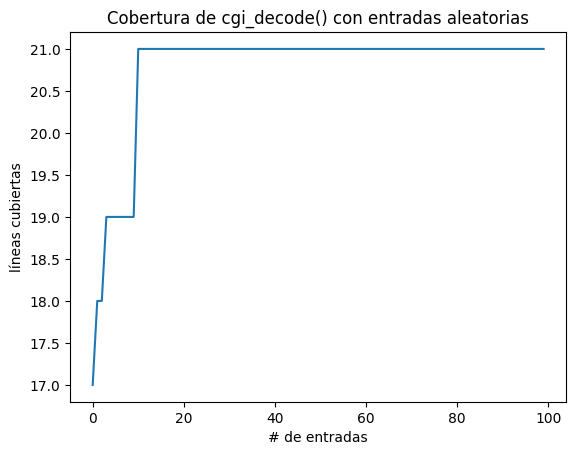

In [29]:
all_coverage, cumulative_coverage = \
    population_coverage(hundred_inputs(), cgi_decode)
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(cumulative_coverage)
plt.title('Cobertura de cgi_decode() con entradas aleatorias')
plt.xlabel('# de entradas')
plt.ylabel('líneas cubiertas')


Esto es solo una ejecución, por supuesto; así que vamos a repetir esto varias veces y a graficar los promedios.


In [30]:
runs = 100

# Create an array with TRIALS elements, all zero
sum_coverage = [0] * trials

for run in range(runs):
    all_coverage, coverage = population_coverage(hundred_inputs(), cgi_decode)
    assert len(coverage) == trials
    for i in range(trials):
        sum_coverage[i] += coverage[i]

average_coverage = []
for i in range(trials):
    average_coverage.append(sum_coverage[i] / runs)

Text(0, 0.5, 'lines covered')

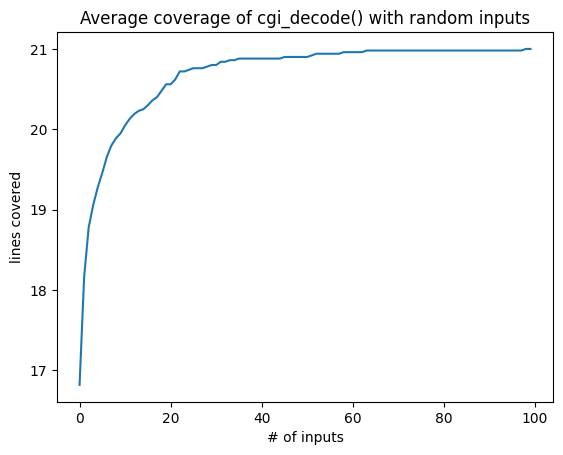

In [31]:
plt.plot(average_coverage)
plt.title('Average coverage of cgi_decode() with random inputs')
plt.xlabel('# of inputs')
plt.ylabel('lines covered')

Vemos que en promedio, obtenemos una cobertura completa después de 40-60 entradas de fuzzing.


## Encontrando Errores con Fuzzing Básico

Dado el tiempo suficiente, podemos cubrir efectivamente cada línea dentro de `cgi_decode()`, sea cual sea el lenguaje de programación. Sin embargo, esto no significa que estén libres de errores. Dado que no verificamos el resultado de `cgi_decode()`, la función podría devolver cualquier valor sin que lo comprobemos o nos demos cuenta. Para detectar tales errores, tendríamos que configurar un verificador de resultados (comúnmente llamado oráculo) que verifique los resultados de las pruebas. En nuestro caso, podríamos comparar las implementaciones en C y Python de `cgi_decode()` y ver si ambas producen los mismos resultados.

Sin embargo, donde el fuzzing es excelente es en encontrar errores internos que pueden ser detectados incluso sin verificar el resultado. De hecho, si ejecutamos nuestro `fuzzer()` en `cgi_decode()`, rápidamente encontramos un error, como muestra el siguiente código:

In [32]:
from fuzzingbook.ExpectError import ExpectError
with ExpectError():
    for i in range(trials):
        try:
            s = fuzzer()
            cgi_decode(s)
        except ValueError:
            pass

Traceback (most recent call last):
  File "/tmp/ipython-input-2121801293.py", line 6, in <cell line: 0>
    cgi_decode(s)
  File "/tmp/ipython-input-1071239422.py", line 22, in cgi_decode
    digit_high, digit_low = s[i + 1], s[i + 2]
                                      ~^^^^^^^
IndexError: string index out of range (expected)


Entonces, es posible hacer que `cgi_decode()` se bloquee. ¿Por qué es eso? Echemos un vistazo a su entrada:


El problema aquí está al final de la cadena. Después de un carácter '%', nuestra implementación siempre intentará acceder a dos caracteres (hexadecimales) más, pero si estos no están presentes, obtendremos una excepción IndexError.

Este problema también está presente en nuestra variante en C, que lo hereda de la implementación original [Pezzè et al, 2008]:

```c
int digit_high = *++s;
int digit_low = *++s;
```

Aquí, `s` es un puntero al carácter que se va a leer; `++` lo incrementa en un carácter. En la implementación en C, el problema es realmente mucho peor. Si el carácter '%' está al final de la cadena, el código anterior primero leerá un carácter de terminación ('\0' en cadenas C) y luego el siguiente carácter, que puede ser cualquier contenido de memoria después de la cadena, y que por lo tanto puede hacer que el programa falle de manera incontrolable. La noticia algo buena es que '\0' no es un carácter hexadecimal válido, y por lo tanto, la versión en C "solo" leerá un carácter más allá del final de la cadena.

Curiosamente, ninguna de las pruebas manuales que habíamos diseñado anteriormente desencadenaría este error. De hecho, ni la cobertura de declaraciones ni la de ramas, ni ninguno de los criterios de cobertura comúnmente discutidos en la literatura lo encontrarían. Sin embargo, una simple ejecución de fuzzing puede identificar el error con unas pocas ejecuciones, si se implementan comprobaciones de tiempo de ejecución adecuadas que detecten estos desbordamientos. ¡Esto definitivamente exige más fuzzing!
